Project Title: Understanding Clouds from Satellite Images

Team Members: Rueen Fiez, Nareshkumar Patel, Nisarg Patel

Course: UFT 3546 - Deep Learning

Instructor: Sina Jamshidi

Session: Dec 2019

Kaggle / Dataset: https://www.kaggle.com/c/understanding_cloud_organization/data

Mask R-CNN Library: https://github.com/matterport/Mask_RCNN

# Setup

---



In [1]:
### IMPORT ALL OF THE LIBRARIES ###
import os # For Directory Manipulation
import tensorflow as tf # backend for keras
import keras # for neural net
import pandas as pd # For reading in CSV file
import cv2 # For image manipulation
import matplotlib.pyplot as plt # For plots
import numpy as np # numpy array
import math # to check nan values
from sklearn.model_selection import train_test_split # for splitting the train and val set
import seaborn as sns # for displaying a heatmap

Using TensorFlow backend.


In [2]:
print(keras.__version__) # Print Keras Version 
# # If version is not 2.2.5 update it.
# if(keras.__version__ != "2.2.5"):
#   print("Upgrading Keras Version to v2.2.5")
#   !pip install keras==2.2.5

2.2.5


In [3]:
print(tf.__version__) # Print TensorFlow Version. 
# # If version is not 1.15.0 update it.
# if(tf.__version__ != "1.15.0"):
#   print("Upgrading TensorFlow Version to v1.15.0")
#   !pip install tensorflow==1.15.0

1.15.0


In [4]:
# We will use matplotlib 3.1.0 because 3.1.1 has error when creating a heatmap
import matplotlib
print(matplotlib.__version__) # Print Matplotlib Version.
# If version is not 3.1.0 update it.
if(matplotlib.__version__ != "3.1.0"):
  print("Upgrading Matplotlib Version to v3.1.0")
  !pip install matplotlib==3.1.0

3.1.0


# Data Preparation
---



In [5]:
### MOUNT GOOGLE DRIVE FOR USE ###
from google.colab import drive
drive.mount('/content/drive' , force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Create Folder Paths

---



In [6]:
### DIRECTORY SETUP ###
ROOT_PATH = "/content/drive/My Drive/Final_Project_3546_Deep_Learning" # if running colab copy
#ROOT_PATH = os.getcwd() # if running local copy
os.chdir(ROOT_PATH) # Change the current working directory
print("Current Working Directory: ", os.getcwd()) # Verify the current working directory

Current Working Directory:  /content/drive/My Drive/Final_Project_3546_Deep_Learning


In [7]:
### CREATE A LIST FOR CLOUD TYPES ###
CLOUD_TYPES = ["Fish","Flower","Gravel","Sugar"]

### CREATE PATHS FOR LOCATING TRAING & TEST DATASET ###
TRAIN_IMGS_PATH = os.path.join(ROOT_PATH, "train_images")
TRAIN_IMAGE_MASKS_PATH = os.path.join(ROOT_PATH, "train.csv")
# Note Test Set doesnt have Annotated masks
TEST_IMGS_PATH = os.path.join(ROOT_PATH, "test_images") 

### CREATE A PATH FOR MASK_RCNN Library ###
MASK_RCNN_PATH = os.path.join(ROOT_PATH, "Mask_RCNN") 

### PRINT PATHS FOR VISUAL VERIFICATION ###
print("Train Images Path:", TRAIN_IMGS_PATH)
print("Train Images Masks Path:", TRAIN_IMAGE_MASKS_PATH)
print("Test Images Path:", TEST_IMGS_PATH)
print("Mask RCNN Model Path:", MASK_RCNN_PATH)


Train Images Path: /content/drive/My Drive/Final_Project_3546_Deep_Learning/train_images
Train Images Masks Path: /content/drive/My Drive/Final_Project_3546_Deep_Learning/train.csv
Test Images Path: /content/drive/My Drive/Final_Project_3546_Deep_Learning/test_images
Mask RCNN Model Path: /content/drive/My Drive/Final_Project_3546_Deep_Learning/Mask_RCNN


In [8]:
### COUNT THE NUMBER OF IMAGES INSIDE THE FOLDER ###
num_train_images = len(os.listdir(TRAIN_IMGS_PATH))
num_test_images = len(os.listdir(TEST_IMGS_PATH))

print ("# of Train Images:", num_train_images)
print ("# of Test Images:", num_test_images)

### IMPORTANT NOTE ###
# Since the test images dataset doesnt contain mask information and annotation
# we will not be using the test dataset to perform test measurements on our model.
# The test dataset that has been provided is solely for the purpose of the kaggle
# competition evaluation standings and checking the model for production.

# Instead, our team has decided to use the train set and use the random split
# to split the train set as following:
# Train Set Directory Images: 5546 images
# Train Set for training the model: 4436 images (80%)
# Validation Set for checking the model' performance: 1110 (20%)
# Please note that the 80% - 20% split is random split.

# of Train Images: 5546
# of Test Images: 3698


### Reading Train Masks CSV File

---



In [9]:
train_masks = pd.read_csv(TRAIN_IMAGE_MASKS_PATH) # Read the CSV file that contains the train masks
train_masks # Shows a glimpse of the CSV File

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...
...,...,...
22179,ffd6680.jpg_Sugar,NaN
22180,ffea4f4.jpg_Fish,NaN
22181,ffea4f4.jpg_Flower,1194860 675 1196260 675 1197660 675 1199060 67...
22182,ffea4f4.jpg_Gravel,NaN


In [10]:
train_masks.describe() # Give a summary

,Image_Label,EncodedPixels
count,22184,11836
unique,22184,11836
top,77c8016.jpg_Sugar,1027507 4 1028907 4 1031292 1 1031294 5 103130...
freq,1,1


### Verify Train Dataset

---



In [0]:
train_masks.insert(1, "Cloud_Label", "") # Add a new column to the dataframe that will hold Cloud type

In [0]:
# Split the Image_Label Column data into Image_File Name and Cloud_Type
# This will help us when working with the data and verify the dataset for integrity
for i in range(0, train_masks["Image_Label"].count()): # Go through all rows
  temp_string = (train_masks.iat[i, 0]).split("_",1) # Split the string into a list with _ separator
  train_masks.iat[i, 0] = temp_string[0] # Train Image Name
  train_masks.iat[i, 1] = temp_string[1] # Cloud Type

In [13]:
train_masks # Show the Dataframe again for visual

,Image_Label,Cloud_Label,EncodedPixels
0,0011165.jpg,Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg,Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg,Gravel,NaN
3,0011165.jpg,Sugar,NaN
4,002be4f.jpg,Fish,233813 878 235213 878 236613 878 238010 881 23...
...,...,...,...
22179,ffd6680.jpg,Sugar,NaN
22180,ffea4f4.jpg,Fish,NaN
22181,ffea4f4.jpg,Flower,1194860 675 1196260 675 1197660 675 1199060 67...
22182,ffea4f4.jpg,Gravel,NaN


In [14]:
train_masks.describe() # Describe the Dataframe

,Image_Label,Cloud_Label,EncodedPixels
count,22184,22184,11836
unique,5546,4,11836
top,5ada6a5.jpg,Gravel,1027507 4 1028907 4 1031292 1 1031294 5 103130...
freq,4,5546,1


In [15]:
# Verification # 1 - The Unique value of Image_Label must be equal to the # of images
# in the Train Images Directory
if(len(train_masks["Image_Label"].unique()) == num_train_images):
  print("Verification # 1 succeeded - # of Image Labels are consistent")
else:
  print("Verification # 1 failed - Inconsistent # of Image Labels")

Verification # 1 succeeded - # of Image Labels are consistent


In [16]:
# Verification # 2 - There should be exactly 4 number of cloud types
# and they must be [Sugar, Gravel, Fish, Flower]
cloud_types_list = (train_masks["Cloud_Label"].unique()).tolist() # Create a list of Cloud Types from the CSV file
num_cloud_types = len(cloud_types_list) # Count the # of Unique Cloud Types
result =  all(elem in CLOUD_TYPES for elem in cloud_types_list) # Check if the cloud_types_list list contains the all of the elements CLOUD_TYPES list

if((result) and (num_cloud_types == len(CLOUD_TYPES))): # Check for element and # of cloud type consistency
  print("Verification # 2 succeeded - Cloud Type is consistent")
else:
  print("Verification # 2 failed - Cloud Type is inconsistent")

Verification # 2 succeeded - Cloud Type is consistent


In [17]:
# Verification # 3 - Each and every train image file must have a mask entry in the CSV file
train_imgs_list = os.listdir(TRAIN_IMGS_PATH) # Create a list of file names from the train images directory
train_masks_list = train_masks["Image_Label"].unique() # Create a list of unique train image labels from the CSV file
result = all(elem in train_imgs_list for elem in train_masks_list) # Check if the files in the train images directory have a mask in the CSV as required

if(result):
  print("Verification # 3 succeeded - all files have masks as required")
else:
  print("Verification # 3 failed - some files and their masks are missing in the CSV file")

Verification # 3 succeeded - all files have masks as required


# Exploratory Data Analysis (EDA)
---



In [18]:
# Explore null values from the training Dataframe
print('There are {} rows in train dataframe.'.format(len(train_masks)))
print('There are {} rows with EncodedPixels.'.format(train_masks.EncodedPixels.count()))
print('There are {} rows where EncodedPixels are null.'.format(len(train_masks) - train_masks.EncodedPixels.count()))

train_masks.head() # Show the beginning of the dataframe so you get an idea

There are 22184 rows in train dataframe.
There are 11836 rows with EncodedPixels.
There are 10348 rows where EncodedPixels are null.


,Image_Label,Cloud_Label,EncodedPixels
0,0011165.jpg,Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg,Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg,Gravel,NaN
3,0011165.jpg,Sugar,NaN
4,002be4f.jpg,Fish,233813 878 235213 878 236613 878 238010 881 23...


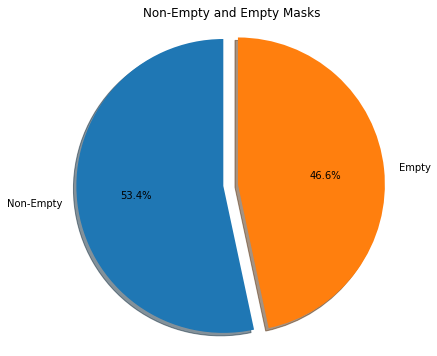

In [19]:
# Ploting a pie chart for Empty and Non-Empty Masks
labels = 'Non-Empty', 'Empty'
sizes = [train_masks.EncodedPixels.count(), len(train_masks) - train_masks.EncodedPixels.count()]
explode = (0,0.1)

figure, axis = plt.subplots(figsize=(6,6))
axis.pie(sizes,explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
axis.axis('equal')
axis.set_title('Non-Empty and Empty Masks')

plt.show() # Show the plot

There are 2781 fish clouds
There are 2365 flower clouds
There are 2939 gravel clouds
There are 3751 sugar clouds


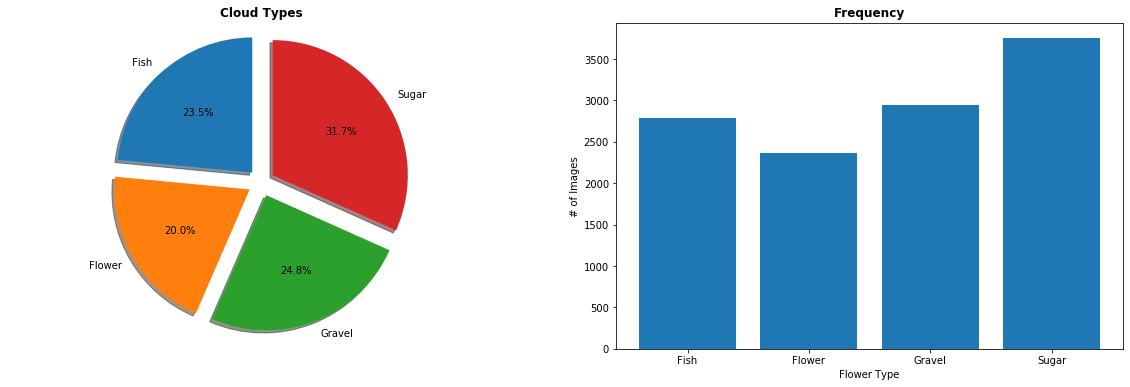

In [20]:
# Explore the Labels
fish_label = train_masks[train_masks['Cloud_Label'] == 'Fish'].EncodedPixels.count()
flower_label = train_masks[train_masks['Cloud_Label'] == 'Flower'].EncodedPixels.count()
gravel_label = train_masks[train_masks['Cloud_Label'] == 'Gravel'].EncodedPixels.count()
sugar_label = train_masks[train_masks['Cloud_Label'] == 'Sugar'].EncodedPixels.count()

print('There are {} fish clouds'.format(fish_label))
print('There are {} flower clouds'.format(flower_label))
print('There are {} gravel clouds'.format(gravel_label))
print('There are {} sugar clouds'.format(sugar_label))

# Plotting a chart for Cloud types
sizes = [fish_label, flower_label, gravel_label, sugar_label]
explode = (0.1, 0.1, 0.1, 0.1)

figure, axis = plt.subplots(1,2, figsize=(20,6))
axis[0].pie(sizes, explode=explode, labels=CLOUD_TYPES, autopct='%1.1f%%', shadow=True, startangle=90)
axis[0].axis('equal')
axis[0].set_title('Cloud Types', fontweight='bold')

axis[1].bar(CLOUD_TYPES, sizes)
axis[1].set_title('Frequency', fontweight='bold')
axis[1].set_xlabel('Flower Type')
axis[1].set_ylabel('# of Images')

plt.show()

In [21]:
labels_per_image = train_masks.groupby('Image_Label')['EncodedPixels'].count()
print('The mean number of labels per image is {}'.format(labels_per_image.mean()))

The mean number of labels per image is 2.134150739271547


Text(0.5, 0, 'How many class lables in a given image')

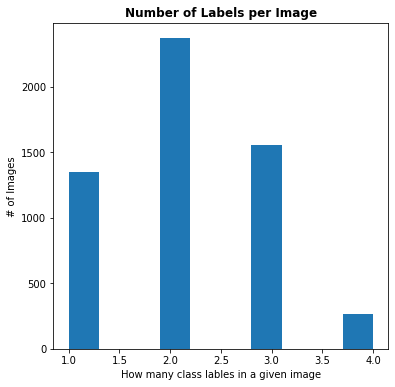

In [22]:
figure, axis = plt.subplots(figsize=(6, 6))
axis.hist(labels_per_image)
axis.set_title('Number of Labels per Image', fontweight='bold')
plt.ylabel("# of Images")
plt.xlabel("How many class lables in a given image")

As the above plot indicates, most image have 2 labels. Now, lets explore the correlation between different cloud types.

In [23]:
# create dummy columns for each cloud type
corr_df = pd.get_dummies(train_masks, columns = ['Cloud_Label'])
# fill null values with '-1'
corr_df = corr_df.fillna('-1')

# define a helper function to fill dummy columns
def get_dummy_value(row, cloud_type):
    ''' Get value for dummy column '''
    if cloud_type == 'fish':
        return row['Cloud_Label_Fish'] * (row['EncodedPixels'] != '-1')
    if cloud_type == 'flower':
        return row['Cloud_Label_Flower'] * (row['EncodedPixels'] != '-1')
    if cloud_type == 'gravel':
        return row['Cloud_Label_Gravel'] * (row['EncodedPixels'] != '-1')
    if cloud_type == 'sugar':
        return row['Cloud_Label_Sugar'] * (row['EncodedPixels'] != '-1')
    
# fill dummy columns
corr_df['Label_Fish'] = corr_df.apply(lambda row: get_dummy_value(row, 'fish'), axis=1)
corr_df['Label_Flower'] = corr_df.apply(lambda row: get_dummy_value(row, 'flower'), axis=1)
corr_df['Label_Gravel'] = corr_df.apply(lambda row: get_dummy_value(row, 'gravel'), axis=1)
corr_df['Label_Sugar'] = corr_df.apply(lambda row: get_dummy_value(row, 'sugar'), axis=1)

# check the result
corr_df.head()

,Image_Label,EncodedPixels,Cloud_Label_Fish,Cloud_Label_Flower,Cloud_Label_Gravel,Cloud_Label_Sugar,Label_Fish,Label_Flower,Label_Gravel,Label_Sugar
0,0011165.jpg,264918 937 266318 937 267718 937 269118 937 27...,1,0,0,0,1,0,0,0
1,0011165.jpg,1355565 1002 1356965 1002 1358365 1002 1359765...,0,1,0,0,0,1,0,0
2,0011165.jpg,-1,0,0,1,0,0,0,0,0
3,0011165.jpg,-1,0,0,0,1,0,0,0,0
4,002be4f.jpg,233813 878 235213 878 236613 878 238010 881 23...,1,0,0,0,1,0,0,0


In [24]:
# group by the image
corr_df = corr_df.groupby('Image_Label')['Label_Fish', 'Label_Flower', 'Label_Gravel', 'Label_Sugar'].max()
corr_df.head()

,Label_Fish,Label_Flower,Label_Gravel,Label_Sugar
Image_Label,,,,
0011165.jpg,1,1,0,0
002be4f.jpg,1,1,0,1
0031ae9.jpg,1,1,0,1
0035239.jpg,0,1,1,0
003994e.jpg,1,0,1,1


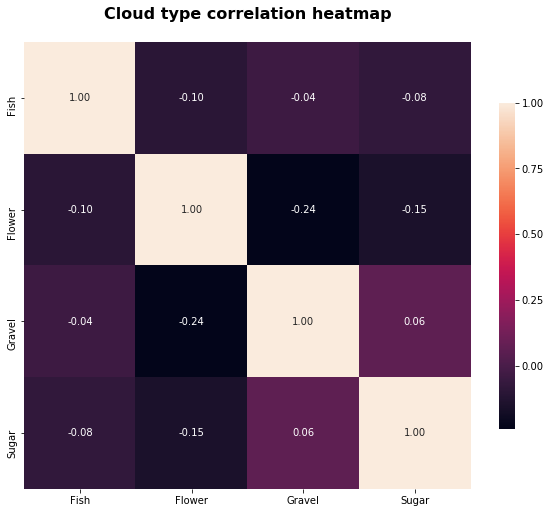

In [25]:
# Find out correlation between columns and plot
corrs = np.corrcoef(corr_df.values.T)

plt.figure(figsize = (10,10))
hm = sns.heatmap(corrs, cbar = True, cbar_kws={"shrink": .60}, annot=True,
               square = True, fmt = '.2f', yticklabels = CLOUD_TYPES, 
               xticklabels = CLOUD_TYPES).set_title('Cloud type correlation heatmap\n', fontweight='bold', fontsize=16)
plt.show()

As we can observe, there is no strong correlation between the types of the clouds on one image (all the correlation coefficients are close to zero).

# Implementing Helper Functions

---



## Run Length Decoding

---



In [0]:
# This function decodes the given mask as a string input from the CSV File
def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
  '''
  Decode rle encoded mask.
  
  :param mask_rle: run-length as string formatted (start length)
  :param shape: (height, width) of array to return 
  Returns numpy array, 1 - mask, 0 - background
  '''
  if(isinstance(mask_rle, str)): # String datatype then it has encoded pixels, extract mask
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
  else: # NaN, Float type, no mask, so zero numpy array
    img = np.zeros((1400, 2100))
    
  return img.reshape(shape, order='F')

## Train & Validation Split

---



In [0]:
def split_dataset(image_file_names, train_size):
  train_set, val_set = train_test_split(image_file_names, train_size = train_size, random_state=42)
  return train_set, val_set

# Split the train set into 80% training and 20% validation set
train_set_list, val_set_list = split_dataset(train_imgs_list, 0.80)

# Mask R-CNN Model
---



## Install Mask R-CNN Library

---



In [28]:
# Before proceeding make sure you have download the github repo and extracted 
# the folder inside the ROOT_PATH where the jupyter notebook is
os.chdir(MASK_RCNN_PATH) # Switch present working directory inside the Mask_RCNN Folder to perform installation
!python setup.py install # Install the Mask R-CNN Library by calling the setup 
os.chdir(ROOT_PATH) # Change the current directory back to the root

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling build/bdist.linux-x86_64/egg/mrcnn/config.py to config.cp

In [29]:
!pip show mask-rcnn # Verify installation

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg
Requires: 
Required-by: 


## Mask R-CNN Imports

---



In [0]:
# Import Mask R-CNN
os.sys.path.append(MASK_RCNN_PATH) # To find local version of the library
from mrcnn.utils import Dataset
from mrcnn import visualize
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn import utils

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_PATH, "logs")

## Class Definitions

---



### Dataset Class

---



In [0]:
# Class that defines and loads the Cloud Images Dataset into the Mask R-CNN model
# Since we are using Mask R-CNN on our own dataset we have to implement the Class
class CloudImagesDataset(Dataset):

  # load the dataset definitions
  # this function is responsible for defining the classes and images in the dataset
  def load_dataset(self, dataset_dir, image_list):
    # define the classes
    for i in range(0,len(CLOUD_TYPES)):
      self.add_class("cloudimages", i+1, CLOUD_TYPES[i]) # 0 is reserved for Background
    
    # add all images from the given image_list
    for i in image_list:
      self.add_image("cloudimages", image_id = i, path = os.path.join(dataset_dir,i))

  # load the masks for an image
  def load_mask(self, image_id):
    # get details of image
    info = self.image_info[image_id]
    image_name = info['id']

    # Filter the dataframe and find all entries for the matching image name
    temp = train_masks[train_masks.Image_Label == image_name]
    #mask_dict = {} # Add cloud name and decoded image with masks 
    #mask_list = []
    mask_array = np.ndarray([1400, 2100, 4], dtype=np.uint8) # numpy array that holds the masks

    for i in range(0,len(temp.values)): # loop through all matching values in frame
      cloud_type = temp.values[i][1] # extract cloud type
      encoded_pix = temp.values[i][2] # extract encoded pixels
      mask_image = rle_decode(encoded_pix) # decode rle encoded pixels
      #mask_dict[cloud_type] = mask_image # append to the dictionary
      #mask_list.append(mask_image) # append to the mask list
      mask_array[:,:,i] = mask_image

    class_id = [1,2,3,4] # Define the class IDS
    class_id = np.array(class_id, dtype='int32') # Conver the class IDs into numpy array
    return mask_array, class_id # return masks and class IDs

  # load an image reference
  def image_reference(self, image_id):
    info = self.image_info[image_id]
    return info['id'] # returns the image file name given the image_id
    #return info['path']

### Configuration Class

---



In [0]:
# define a configuration for the model
class CloudImagesConfig(Config):
	# Give the configuration a recognizable name
	NAME = "cloudimages"
	# Number of classes (background + fish + flower + gravel + sugar)
	NUM_CLASSES = 1 + 4
	# NUMBER OF GPUs to use. When using only a CPU, this needs to be set to 1.
	# we will be using the CPU for training // Mask RCNN default
	GPU_COUNT = 1
	# Number of images that can fit the GPU - leave it to default
	IMAGES_PER_GPU = 2
	# Batch Size
	BATCH_SIZE = GPU_COUNT * IMAGES_PER_GPU # Mask RCNN Model Default
	# Number of training steps per epoch
	STEPS_PER_EPOCH =  math.ceil((num_train_images - len(val_set_list)) / BATCH_SIZE)
	# Validation steps
	VALIDATION_STEPS = math.ceil(len(val_set_list) / BATCH_SIZE)
	

###Inference Class

---



In [0]:
# define a the inference configuration class for the model which can be used for testing
class InferenceConfig(CloudImagesConfig):
    GPU_COUNT = 1 # Leave it to 1 as we will be running it on a CPU
    IMAGES_PER_GPU = 1 # Number of Images per GPU. Leave it to 1

## Loading Training Data

---



In [34]:
# prepare train set
train_set = CloudImagesDataset() # Create a new class instance
train_set.load_dataset(TRAIN_IMGS_PATH, train_set_list) # load the dataset by specifying the train directory
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
val_set = CloudImagesDataset() # Create a new class instance
val_set.load_dataset(TRAIN_IMGS_PATH, val_set_list) # load the dataset by specifying the train directory
val_set.prepare()
print('Validation: %d' % len(val_set.image_ids))

Train: 4436
Validation: 1110


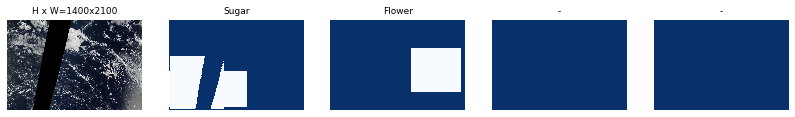

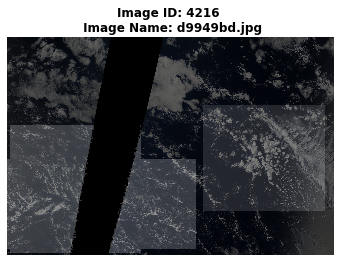

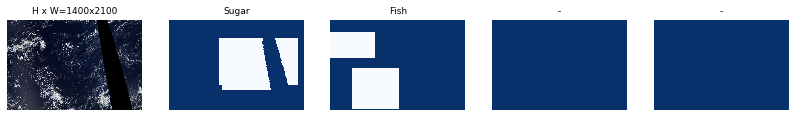

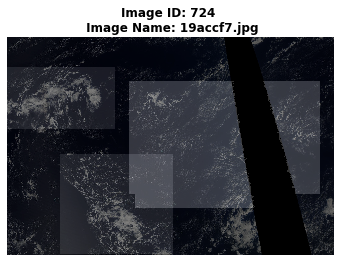

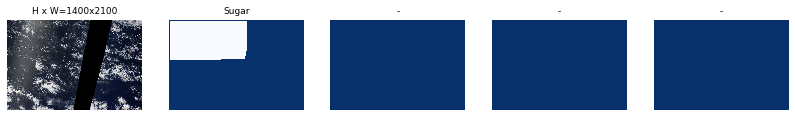

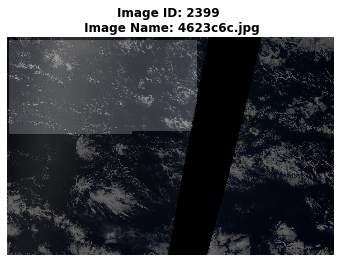

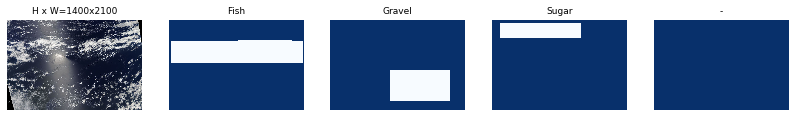

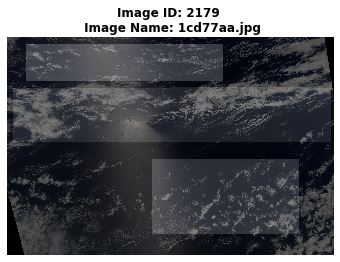

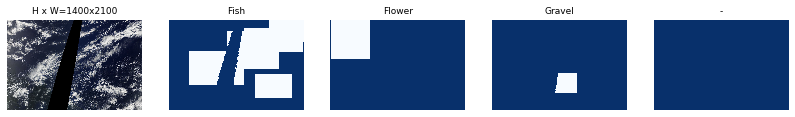

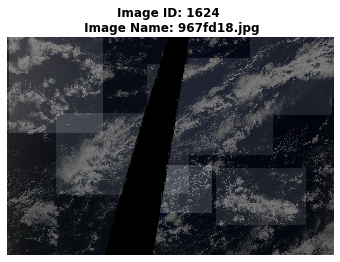

In [35]:
# randomly choose 5 pictures from the train dataset
image_ids = np.random.choice(train_set.image_ids, 5) 

### Go through each image, load it, load mask, use visualize to display all 
### masks, and show one picture with all masks
for image_id in image_ids: # loop through all images
    image = train_set.load_image(image_id) # load the image
    mask_array, class_ids = train_set.load_mask(image_id) # load the masks

    visualize.display_top_masks(image, mask_array, class_ids, train_set.class_names) # display the image with all masks
    
    # Show all possible masks over the original images as an overlay
    plt.imshow(image) # show the loaded raw image
    for i in class_ids: # loop through all class_ids aka cloud types
      plt.imshow(mask_array[:, :, i-1], cmap='gray', alpha=0.2) # show mask for each class with 0.2 alpha value
    plt.title("Image ID: %s \n Image Name: %s" % (image_id, train_set.image_reference(image_id)), fontweight='bold') # Create a plot title
    plt.grid(False)
    plt.axis('off')
    plt.show() # show the plot

## Model Training
---



In [35]:
# prepare config
config = CloudImagesConfig()
config.display() # display configuration


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
# Create model in training mode
model = MaskRCNN(mode='training', model_dir=MODEL_DIR, config=config)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [0]:
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [0]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers.
model.train(train_set, val_set,
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/Final_Project_3546_Deep_Learning/logs/cloudimages20191129T0319/mask_rcnn_cloudimages_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/1
2218/2218 [==============================] - 5166s 2s/step - loss: 2.0230 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.6503 - mrcnn_class_loss: 0.3438 - mrcnn_bbox_loss: 0.5511 - mrcnn_mask_loss: 0.4564 - val_loss: 1.8718 - val_rpn_class_loss: 0.0182 - val_rpn_bbox_loss: 0.5820 - val_mrcnn_class_loss: 0.3423 - val_mrcnn_bbox_loss: 0.5075 - val_mrcnn_mask_loss: 0.4217



In [0]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(train_set, val_set, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=5, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /content/drive/My Drive/Final_Project_3546_Deep_Learning/logs/cloudimages20191129T0319/mask_rcnn_cloudimages_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNo

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 2/5
2218/2218 [==============================] - 8184s 4s/step - loss: 1.7489 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.5515 - mrcnn_class_loss: 0.3188 - mrcnn_bbox_loss: 0.4577 - mrcnn_mask_loss: 0.4043 - val_loss: 1.7300 - val_rpn_class_loss: 0.0168 - val_rpn_bbox_loss: 0.5380 - val_mrcnn_class_loss: 0.3185 - val_mrcnn_bbox_loss: 0.4555 - val_mrcnn_mask_loss: 0.4012
Epoch 3/5
2218/2218 [==============================] - 7991s 4s/step - loss: 1.6970 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5240 - mrcnn_class_loss: 0.3125 - mrcnn_bbox_loss: 0.4474 - mrcnn_mask_loss: 0.3974 - val_loss: 1.6486 - val_rpn_class_loss: 0.0142 - val_rpn_bbox_loss: 0.5039 - val_mrcnn_class_loss: 0.3050 - val_mrcnn_bbox_loss: 0.4335 - val_mrcnn_mask_loss: 0.3921
Epoch 4/5
2218/2218 [==============================] - 8029s 4s/step - loss: 1.6294 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.4985 - mrcnn_class_loss: 0.2918 - mrcnn_bbox_loss: 0.4294 - mrcnn_mask_loss: 0.3943 - val_loss: 1.6516 - val_rpn_c

In [0]:
# Create a path for saving model weights
model_weights_path = os.path.join(ROOT_PATH, "mask_rcnn_cloudimages.h5")

# Save weights for future reference
model.keras_model.save_weights(model_weights_path) # save model weights

## Load Model & Test

---



In [36]:
inference_config = InferenceConfig()
# Recreate the model in inference mode
model = MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [37]:
# Get path to saved weights
# Either set a specific path or find last trained weights
model_path_wload = os.path.join(ROOT_PATH, "mask_rcnn_cloudimages.h5")

# Load trained weights
print("Loading weights from ", model_path_wload)
model.load_weights(model_path_wload, by_name=True)
print("Model weights loading successful")

Loading weights from  /content/drive/My Drive/Final_Project_3546_Deep_Learning/mask_rcnn_cloudimages.h5






Model weights loading successful


In [40]:
# This function plots the actual image masks and predicted masks along with
# instance segmentation from the trained model. Please note: it uses training set
def show_actual_vs_predicted(im_list): # takes a list of image list
  for image_id in im_list: # loop through all images

    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(train_set, inference_config, 
                              image_id, use_mini_mask=False)

    log("original_image", original_image)
    log("image_meta", image_meta)
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
    fig.tight_layout() # Squeeze for space savings
    fig.suptitle("Image ID: %s \n Image Name: %s" % (image_id, 
                                                     train_set.image_reference(image_id)), 
                 fontweight='bold',  verticalalignment='center', fontsize=16)
    
    # Show the actual results
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                train_set.class_names, ax=axes[0], figsize=(10, 6))
    axes[0].set_title('Actual', fontweight='bold', fontsize=14)

    # Show the predicted results
    results = model.detect([original_image], verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                val_set.class_names, r['scores'], ax=axes[1], figsize=(5, 5))
    axes[1].set_title('Predicted', fontweight='bold', fontsize=14)

    # Show the plot
    plt.show()
    
# Randomly select 7 images from the train set
image_random_list = np.random.choice(train_set.image_ids, 7)
# Show the actual vs predicted for the random 7 images from the train set
show_actual_vs_predicted(image_random_list)

Output hidden; open in https://colab.research.google.com to view.

## Evaluating Model
---

In [0]:
# We will use mean Average Precision score to get the evaluation metrics for
# the bounding box and the semantic segmentation

# This function will calculate the mean average precision score for a given dataset
# model and inference configuration provided
def get_eval_metric(dataset, model, inf_config):
  APs = [] # list to hold average precision scores
  for image_ID in dataset.image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, inf_config, image_ID, use_mini_mask=False)

    # Convert pixel values
    molded_images = np.expand_dims(modellib.mold_image(image, inf_config), 0)
    
    # Run object detection on that sample
    results = model.detect([image], verbose=0)
    r = results[0]

    # Compute AP, Precision, Recall & Overalap metric
    AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        
    # Add the scores to the Average Precision score list
    APs.append(AP)
  
  return np.mean(APs) # return the mean average precision score

In [0]:
# Mean Average Precision score for Training Set
print("Train Set mAP: ", get_eval_metric(train_set, model, inference_config))

Train Set mAP:  0.24895426446444854


In [0]:
# Mean Average Precision score for Val Set
print("Validation Set mAP: ", get_eval_metric(val_set, model, inference_config))

Validation Set mAP:  0.23210710847789456
